## Lueders et al., 2004 (barkeri & extorquens)
 
* strain(s)
  * Methylobacterium extorquens AM1 DSM 1338
    * genome G+C = 68.7
  * M. barkeri DSM 800
    * *aka* Methanosarcina barkeri MS
    * genome G+C = 39.2
* isotope(s)
  * <sup>13</sup>C
  * assumed 100% incorporation
* gradient
  * rotor
    * TV865 vertical rotor (Sorvall)
      * vertical rotor
  * CsCl density
    * 1.725 g/ml
  * centrifugation 
    * 20<sup>o</sup>C
    * \>36h 
    * 45,000 r.p.m. (177,000 gav)
  * fractionation volume
    * 400 ul

* DNA quantification
  * both qPCR & fluorometrically
  * qPCR primers
    * Ar109f/Ar915r (Lueders and Friedrich, 2003) 
      * Ar109f (ACKGCTCAGTAACACGT)
      * Ar915r (GTGCTCCCCCGCCAATTCCT)
    * Ba519f/Ba907 (Stubner, 2002)
      * Ba519f (CAGCMGCCGCGGTAANWC)
      * Ba907r (CCGTCAATTCMTTTRAGTT)

# Setting variables

In [289]:
workDir = '/home/nick/notebook/SIPSim/dev/Leuders2004/'

# params
bandwidth = 0.2

# Init

In [323]:
import os
import dill
import numpy as np
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [577]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(genomes)
library(gridExtra)

In [292]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/nick/notebook/SIPSim/dev/Leuders2004


# Getting genomes

In [5]:
%%R
data(proks)
summary(proks)

$`Total genomes`
[1] 27570 genome projects on Sep 04, 2014

$`By status`
                     Total
Contig               13074
Scaffold             10718
Gapless Chromosome    3053
Chromosome             373
Chromosome with gaps   343
Complete                 9

$`Recent submissions`
  released   name                      status  
1 2014-09-02 Altuibacter lentus        Scaffold
2 2014-09-02 Bacillus cereus ATCC 4342 Scaffold
3 2014-09-02 Bacillus licheniformis    Scaffold
4 2014-09-02 Bacillus megaterium       Scaffold
5 2014-09-02 Paenibacillus macerans    Scaffold



In [6]:
%%R
update(proks)
summary(proks)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: proks has been successfully updated

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 33548 new project IDs added

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 246 old project IDs removed

  res = super(Function, self).__call__(*new_args, **new_kwargs)


$`Total genomes`
[1] 61484 genome projects on Mar 11, 2016

$`By status`
                Total
Contig          28292
Scaffold        27266
Complete Genome  5039
Chromosome        887

$`Recent submissions`
  released   name                         status  
1 2016-03-04 Akkermansia sp. KLE1798      Scaffold
2 2016-03-04 Escherichia coli             Contig  
3 2016-03-03 Bacillus cereus              Scaffold
4 2016-03-03 Bacteroides cellulosilyticus Scaffold
5 2016-03-03 Bacteroides fragilis         Scaffold



In [ ]:
%%R
M.ext = subset(proks, name %like% 'Methylobacterium extorquens AM1*')
M.bark = subset(proks, name %like% 'Methanosarcina barkeri MS*')
orgs = rbind(M.ext, M.bark)


orgFile = 'genome_info.txt'
write.table(orgs, orgFile, sep='\t', quote=FALSE, row.names=FALSE)
cat('File written:', orgFile, '\n')

In [ ]:
!seqDB_tools accession-GI2fasta \
        -a 11 -n 2 -f 30 -header \
        -o genomes \
        genome_info.txt 

In [ ]:
!ls -thlc genomes/*.fna

## renaming genome sequences

In [ ]:
!find ./genomes/ -name "*.fna" |\
    xargs -P 2 -I % SIPSim genome_rename --prefix genomes_rn %

## Indexing genomes

In [ ]:
# making a genome index file
## taxonName<tab>genomeSeqFileName
!ls -1 genomes_rn/*fna | perl -pe 's/.+\/|\.fna//g; s/(.+)/$1\t$1.fna/' > genome_index.txt
!cat genome_index.txt

In [ ]:
!SIPSim genome_index \
    --fp ./genomes_rn/ \
    --np 2 \
    genome_index.txt \
    > genome_index.log
    
!tail genome_index.log    

# Simulating a gradient community

In [8]:
comm = """library	taxon_name	rel_abund_perc	rank
1	Methanosarcina_barkeri_MS	100.0	1
1	Methylobacterium_extorquens_AM1	0.0	2
2	Methylobacterium_extorquens_AM1	100.0	1
2	Methanosarcina_barkeri_MS	0.0	2
"""

comm_file = 'comm-n2-unif.txt'
with open(comm_file, 'wb') as oFH:
    oFH.write(comm)
    
!cat $comm_file

library	taxon_name	rel_abund_perc	rank
1	Methanosarcina_barkeri_MS	100.0	1
1	Methylobacterium_extorquens_AM1	0.0	2
2	Methylobacterium_extorquens_AM1	100.0	1
2	Methanosarcina_barkeri_MS	0.0	2


# Simulating gradient fractions

In [117]:
!SIPSim gradient_fractions \
    --BD_min 1.66 \
    --BD_max 1.8 \
    --params mu:0.0075,sigma:0.001 \
    comm-n2-unif.txt \
    > fracs-n2-unif.txt

!wc -l fracs-n2-unif.txt
!head -n 5 fracs-n2-unif.txt
!tail -n 5 fracs-n2-unif.txt

39 fracs-n2-unif.txt
library	fraction	BD_min	BD_max	fraction_size
1	1	1.66	1.662	0.002
1	2	1.662	1.668	0.006
1	3	1.668	1.676	0.008
1	4	1.676	1.684	0.008
2	15	1.76	1.767	0.007
2	16	1.767	1.777	0.01
2	17	1.777	1.785	0.008
2	18	1.785	1.792	0.007
2	19	1.792	1.8	0.008


Source: local data frame [2 x 2]

  library     n
    (int) (int)
1       1    19
2       2    19


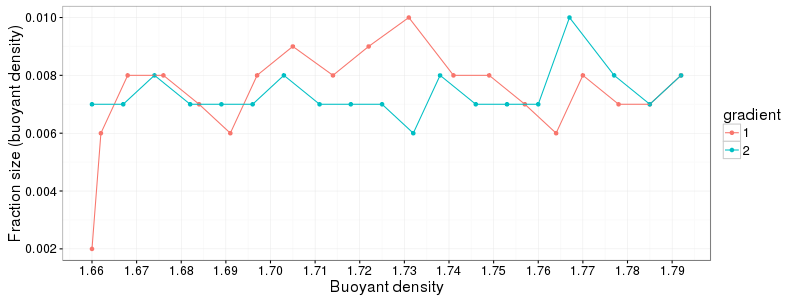

In [118]:
%%R -w 800 -h 300
# plotting
df = read.delim('fracs-n2-unif.txt', sep='\t')

df %>%
    group_by(library) %>%
    summarize(n=n()) %>%
    print

ggplot(df, aes(BD_min, fraction_size, group=library, color=library %>% as.character)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks=seq(1.66, 1.8, 0.01)) +
    scale_color_discrete('gradient') +
    labs(x='Buoyant density', y='Fraction size (buoyant density)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# SIPSim of shotgun fragments

* for comparing to fluormetric quanitification

In [32]:
!SIPSim fragments \
    genome_index.txt \
    --fp genomes \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 100X \
    --np 2 \
    2> shotFrag_skewN90-25-n5-nS.log \
    > shotFrag_skewN90-25-n5-nS.pkl
    
!tail shotFrag_skewN90-25-n5-nS.log

Processing: "Methanosarcina_barkeri_MS"
Processing: "Methylobacterium_extorquens_AM1"
  Genome name: Methanosarcina_barkeri_MS
  Genome length (bp): 4533209
  Number of amplicons: None
  Number of fragments simulated: 64391
  Genome name: Methylobacterium_extorquens_AM1
  Genome length (bp): 5511322
  Number of amplicons: None
  Number of fragments simulated: 78333


## Converting to 2d-kde objects

* Also converts fragment G+C to buoyant density

In [293]:
!SIPSim fragment_KDE \
    shotFrag_skewN90-25-n5-nS.pkl \
    --bw $bandwidth \
    > shotFrag_skewN90-25-n5-nS_kde.pkl

!ls -thlc shotFrag_skewN90-25-n5-nS_kde.pkl

-rw-rw-r-- 1 nick nick 2.2M Mar 11 13:23 shotFrag_skewN90-25-n5-nS_kde.pkl


In [604]:
!SIPSim KDE_info -s shotFrag_skewN90-25-n5-nS_kde.pkl

Loading KDEs...
lib_ID	taxon_ID	KDE_ID	min	percentile_5	percentile_25	mean	median	percentile_75	percentile_95	max	stdev
1	Methylobacterium_extorquens_AM1	1	1.70360132092	1.72327819773	1.7262761602	1.7273283076	1.72761013386	1.728742901	1.73056126207	1.73686173295	0.00241770602417
1	Methylobacterium_extorquens_AM1	2	256.0	4108.0	6109.0	7035.78267142	7301.0	8207.0	9082.0	10740.0	1554.11137688
1	Methanosarcina_barkeri_MS	1	1.68548	1.69394847098	1.69668418292	1.69842993195	1.69846092781	1.7001455066	1.70284808197	1.712675	0.00272249367404
1	Methanosarcina_barkeri_MS	2	124.0	4114.5	6118.0	7040.14853007	7308.0	8214.0	9080.0	10740.0	1551.18266968


### Plotting distributions

In [586]:
n=100000
!SIPSim KDE_sample -n $n shotFrag_skewN90-25-n5-nS_kde.pkl > shotFrag_skewN90-25-n5-nS_kde.txt

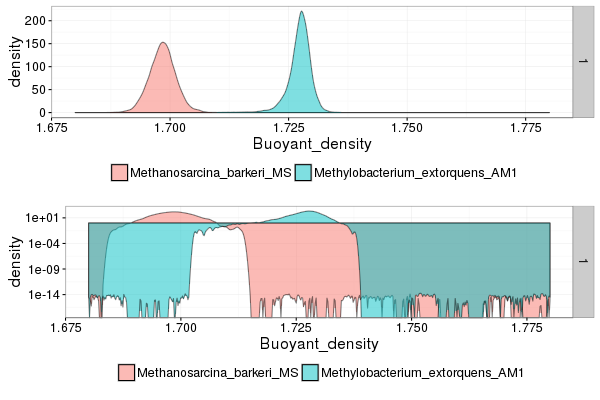

In [588]:
%%R -w 600 -h 400
df = read.delim('shotFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Adding diffusion

In [589]:
!SIPSim diffusion \
    shotFrag_skewN90-25-n5-nS_kde.pkl \
    --np 2 \
    --bw $bandwidth \
    > shotFrag_skewN90-25-n5-nS_dif_kde.pkl
    
!ls -thlc shotFrag_skewN90-25-n5-nS_dif_kde.pkl

Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
-rw-rw-r-- 1 nick nick 7.7M Mar 12 07:41 shotFrag_skewN90-25-n5-nS_dif_kde.pkl


### Plotting distributions

In [590]:
n=100000
!SIPSim KDE_sample -n $n shotFrag_skewN90-25-n5-nS_dif_kde.pkl > shotFrag_skewN90-25-n5-nS_dif_kde.txt

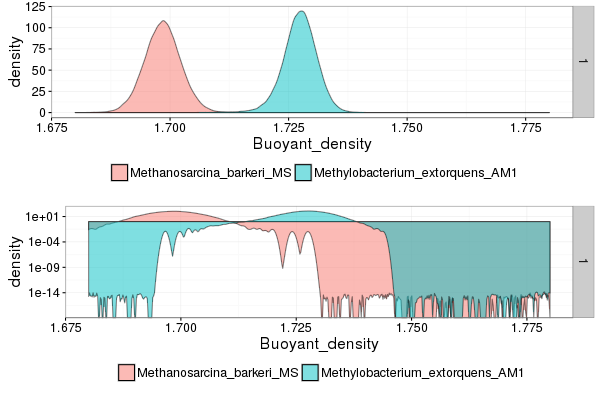

In [591]:
%%R -w 600 -h 400
df = read.delim('shotFrag_skewN90-25-n5-nS_dif_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Adding DBL smearing

In [592]:
!SIPSim DBL \
    shotFrag_skewN90-25-n5-nS_dif_kde.pkl \
    --comm comm-n2-unif.txt \
    --commx 0 \
    -D 1.725 \
    -w 19807714 \
    --tube_height 5.1 \
    --r_min 7.47 \
    --r_max 8.79 \
    --vertical \
    --np 2 \
    > shotFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl

DBL_index file written: "DBL_index.txt"
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS


### Plotting smearing index

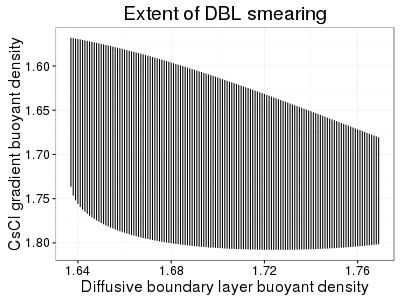

In [593]:
%%R -h 300 -w 400
df = read.delim('DBL_index.txt', sep='\t')

ggplot(df, aes(DBL_BD, ymin=vert_gradient_BD_low, ymax=vert_gradient_BD_high)) +
    geom_linerange() +
    scale_y_reverse() +
    labs(x='Diffusive boundary layer buoyant density', 
         y='CsCl gradient buoyant density',
         title='Extent of DBL smearing') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting distributions

In [594]:
n=100000
!SIPSim KDE_sample -n $n shotFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl > shotFrag_skewN90-25-n5-nS_dif_kde_DBL.txt

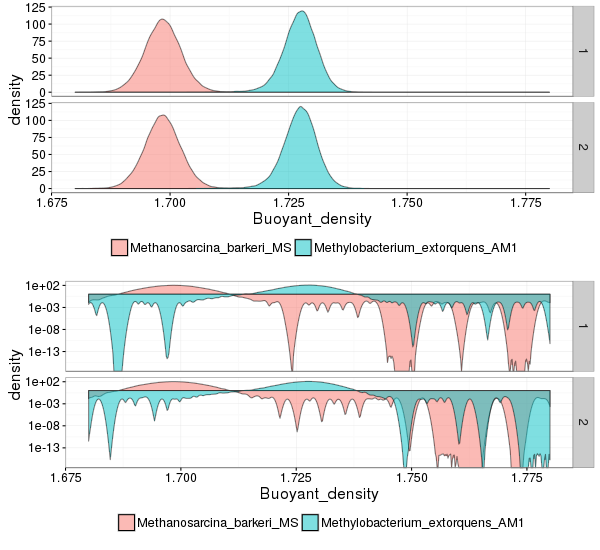

In [595]:
%%R -w 600 -h 550
df = read.delim('shotFrag_skewN90-25-n5-nS_dif_kde_DBL.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Simulating isotope incorporation

In [626]:
# making config file
config = """
[1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
        
[2]
  # half of taxa incorporate
  max_perc_taxa_incorp = 100
  
  [[intraPopDist 1]]
  distribution = uniform

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 100
        end = 100

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 100
        end = 100 
"""

outfile = os.path.join(workDir, 'incorp.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [639]:
!SIPSim isotope_incorp \
    shotFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl \
    incorp.config \
    --comm comm-n2-unif.txt \
    --np 2 \
    > shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl 

Loading KDE object...
Processing library: 1
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing library: 2
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS


### Plotting distributions

In [640]:
n=100000
!SIPSim KDE_sample -n $n shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl \
    > shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.txt

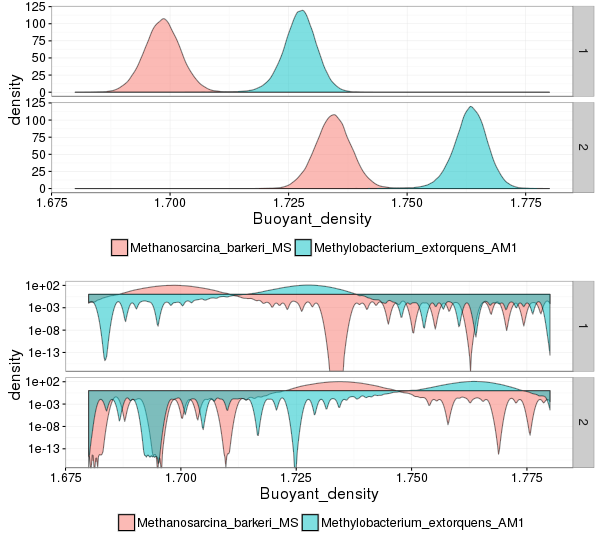

In [641]:
%%R -w 600 -h 550
df = read.delim('shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Making OTU table

In [642]:
!SIPSim OTU_table \
    shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl \
    comm-n2-unif.txt \
    fracs-n2-unif.txt \
    --abs 1e9 \
    --np 2 \
    > shotFrag_OTU_n2_abs1e9.txt
    
!head shotFrag_OTU_n2_abs1e9.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  1000000000
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  0
Processing library: "2"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  0
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  1000000000
library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Methanosarcina_barkeri_MS	-inf-1.660	-inf	1.659	1.659	242381	1.0
1	Methanosarcina_barkeri_MS	1.660-1.662	1.66	1.661	1.662	12842	1.0
1	Methanosarcina_barkeri_MS	1.662-1.668	1.662	1.665	1.668	21449	1.0
1	Methanosarcina_barkeri_MS	1.668-1.676	1.668	1.672	1.676	70809	1.0
1	Methanosarcina_barkeri_MS	1.676-1.684	1.676	1.68	1.684	405597	1.0
1	Methanosarcina_barkeri_MS	1.684-1.691	1.684	1.688	1.691	27305856	1.0
1	Methanosarcina_barkeri_MS	1.691-1.697	1.691	1.694	1.697	322833604	1.0
1	Methanosarcina_barkeri_MS	1.697-1.705	1.697

## Plotting OTU abundances

In [643]:
%%R -i workDir

# loading file
F = file.path(workDir, 'shotFrag_OTU_n2_abs1e9.txt')
df =  read.delim(F)

df1 = df %>%
    filter(library == 1,
           taxon == 'Methanosarcina_barkeri_MS')
df2 = df %>%
    filter(library == 2,
           taxon == 'Methylobacterium_extorquens_AM1')
df = rbind(df1, df2)

df = df %>% 
    group_by(library) %>%
    mutate(rel_abund = count / max(count)) %>%
    ungroup()
df %>% head(n=3) %>% as.data.frame

  library                     taxon    fraction BD_min BD_mid BD_max  count
1       1 Methanosarcina_barkeri_MS  -inf-1.660   -Inf  1.659  1.659 242381
2       1 Methanosarcina_barkeri_MS 1.660-1.662  1.660  1.661  1.662  12842
3       1 Methanosarcina_barkeri_MS 1.662-1.668  1.662  1.665  1.668  21449
     rel_abund
1 4.013854e-04
2 2.126648e-05
3 3.551976e-05


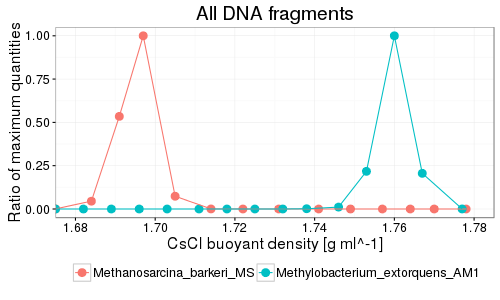

In [644]:
%%R -w 500 -h 300

# max possible shift for M barkeri (using mean G+C)
max_shift = 1.727326 + 0.036

# plotting
p = ggplot(df, aes(BD_min, rel_abund, color=taxon)) +
    geom_point(size=3.5) +
    geom_line() +
    #geom_vline(xintercept=c(1.698416, 1.727326), linetype='dashed', alpha=0.5) +
    #geom_vline(xintercept=c(max_shift), linetype='dashed', alpha=0.5, color='blue') +
    scale_x_continuous(limits=c(1.68, 1.78), breaks=seq(1.68, 1.78, 0.02)) +
    scale_color_discrete('') +
    labs(x='CsCl buoyant density [g ml^-1]', y='Ratio of maximum quantities', 
         title='All DNA fragments') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'bottom'
    )
p

***

# SIPSim of amplicon fragments

* for comparing to qPCR results

## Simulating fragments

In [136]:
# primers
primers = """>Ar109f
ACKGCTCAGTAACACGT
>Ar915r
GTGCTCCCCCGCCAATTCCT
>Ba519f
CAGCMGCCGCGGTAANWC
>Ba907r
CCGTCAATTCMTTTRAGTT
"""
primer_file = 'Ba-Ar_primers.fna'
with open(primer_file, 'wb') as outFH:
    outFH.write(primers)
    
!cat $primer_file

>Ar109f
ACKGCTCAGTAACACGT
>Ar915r
GTGCTCCCCCGCCAATTCCT
>Ba519f
CAGCMGCCGCGGTAANWC
>Ba907r
CCGTCAATTCMTTTRAGTT


In [137]:
!SIPSim fragments \
    genome_index.txt \
    --fp genomes_rn \
    --fr Ba-Ar_primers.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 2 \
    2> ampFrag_skewN90-25-n5-nS.log \
    > ampFrag_skewN90-25-n5-nS.pkl
    
!tail ampFrag_skewN90-25-n5-nS.log    

Processing: "Methanosarcina_barkeri_MS"
Processing: "Methylobacterium_extorquens_AM1"
  Genome name: Methanosarcina_barkeri_MS
  Genome name: Methylobacterium_extorquens_AM1
  Genome length (bp): 4533209
  Number of amplicons: 3
  Number of fragments simulated: 10000
  Genome length (bp): 5511322
  Number of amplicons: 5
  Number of fragments simulated: 10000


## Converting to 2d-kde objects

* Also converts fragment G+C to buoyant density

In [645]:
!SIPSim fragment_KDE \
    ampFrag_skewN90-25-n5-nS.pkl \
    > ampFrag_skewN90-25-n5-nS_kde.pkl

!ls -thlc ampFrag_skewN90-25-n5-nS_kde.pkl

-rw-rw-r-- 1 nick nick 314K Mar 12 09:05 ampFrag_skewN90-25-n5-nS_kde.pkl


### Plotting distributions

In [646]:
n=100000
!SIPSim KDE_sample -n $n ampFrag_skewN90-25-n5-nS_kde.pkl > ampFrag_skewN90-25-n5-nS_kde.txt

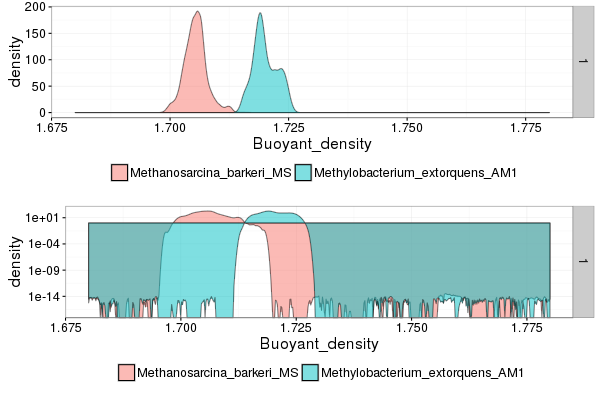

In [647]:
%%R -w 600 -h 400
df = read.delim('ampFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Adding diffusion

In [648]:
!SIPSim diffusion \
    ampFrag_skewN90-25-n5-nS_kde.pkl \
    --np 2 \
    > ampFrag_skewN90-25-n5-nS_dif_kde.pkl
    
!ls -thlc ampFrag_skewN90-25-n5-nS_dif_kde.pkl

Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
-rw-rw-r-- 1 nick nick 7.7M Mar 12 09:06 ampFrag_skewN90-25-n5-nS_dif_kde.pkl


### Plotting distributions

In [649]:
n=100000
!SIPSim KDE_sample -n $n ampFrag_skewN90-25-n5-nS_kde.pkl > ampFrag_skewN90-25-n5-nS_kde.txt

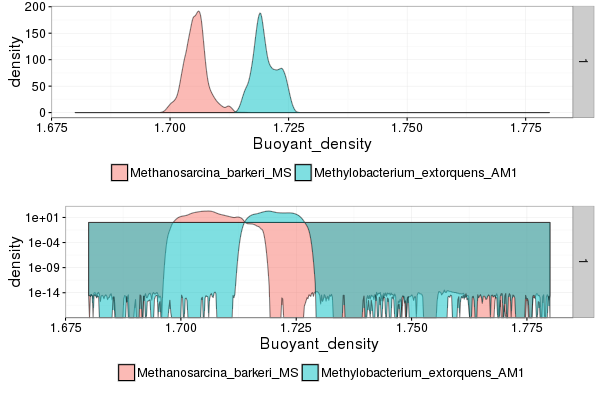

In [650]:
%%R -w 600 -h 400
df = read.delim('ampFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Adding DBL smearing

In [651]:
!SIPSim DBL \
    ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
    --comm comm-n2-unif.txt \
    --commx 0 \
    -D 1.725 \
    -w 19807714 \
    --tube_height 5.1 \
    --r_min 7.47 \
    --r_max 8.79 \
    --vertical \
    --np 2 \
    > ampFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl

DBL_index file written: "DBL_index.txt"
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS


### Plotting smearing index

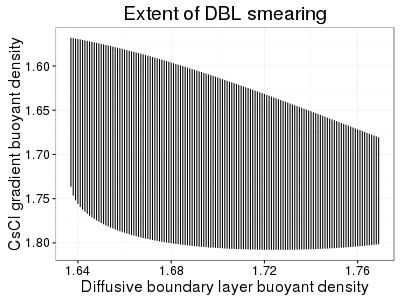

In [652]:
%%R -h 300 -w 400
df = read.delim('DBL_index.txt', sep='\t')

ggplot(df, aes(DBL_BD, ymin=vert_gradient_BD_low, ymax=vert_gradient_BD_high)) +
    geom_linerange() +
    scale_y_reverse() +
    labs(x='Diffusive boundary layer buoyant density', 
         y='CsCl gradient buoyant density',
         title='Extent of DBL smearing') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting distributions

In [653]:
n=100000
!SIPSim KDE_sample -n $n ampFrag_skewN90-25-n5-nS_kde.pkl > ampFrag_skewN90-25-n5-nS_kde.txt

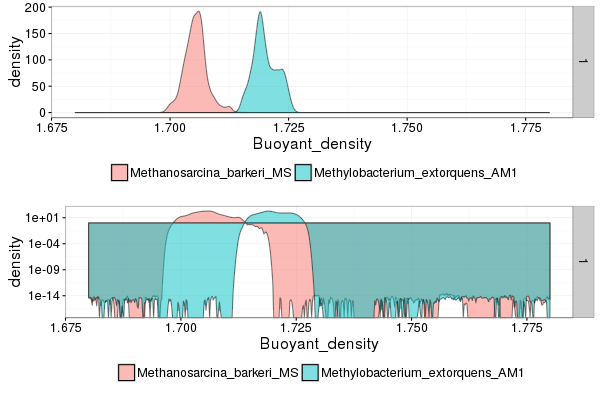

In [654]:
%%R -w 600 -h 400
df = read.delim('ampFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Simulating isotope incorporation

In [655]:
!SIPSim isotope_incorp \
    ampFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl \
    incorp.config \
    --comm comm-n2-unif.txt \
    --np 2 \
    > ampFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl 

Loading KDE object...
Processing library: 1
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing library: 2
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS


### Plotting distributions

In [656]:
n=100000
!SIPSim KDE_sample -n $n ampFrag_skewN90-25-n5-nS_kde.pkl > ampFrag_skewN90-25-n5-nS_kde.txt

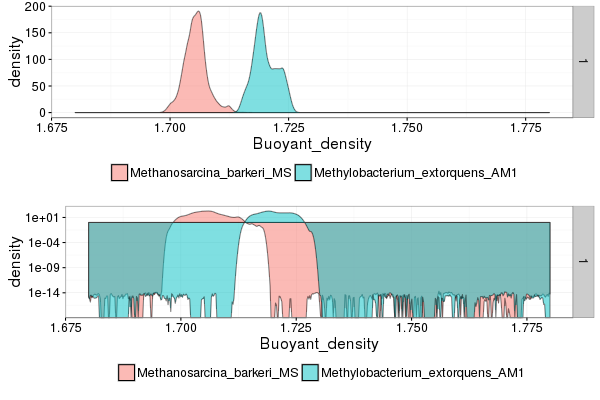

In [657]:
%%R -w 600 -h 400
df = read.delim('ampFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Making OTU table

In [658]:
!SIPSim OTU_table \
    ampFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl \
    comm-n2-unif.txt \
    fracs-n2-unif.txt \
    --abs 1e9 \
    --np 2 \
    > ampFrag_OTU_n2_abs1e9.txt
    
!head ampFrag_OTU_n2_abs1e9.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  1000000000
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  0
Processing library: "2"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  0
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  1000000000
library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Methanosarcina_barkeri_MS	-inf-1.660	-inf	1.659	1.659	184681	1.0
1	Methanosarcina_barkeri_MS	1.660-1.662	1.66	1.661	1.662	6726	1.0
1	Methanosarcina_barkeri_MS	1.662-1.668	1.662	1.665	1.668	30548	1.0
1	Methanosarcina_barkeri_MS	1.668-1.676	1.668	1.672	1.676	44986	1.0
1	Methanosarcina_barkeri_MS	1.676-1.684	1.676	1.68	1.684	29965	1.0
1	Methanosarcina_barkeri_MS	1.684-1.691	1.684	1.688	1.691	99454	1.0
1	Methanosarcina_barkeri_MS	1.691-1.697	1.691	1.694	1.697	6674508	1.0
1	Methanosarcina_barkeri_MS	1.697-1.705	1.697	1.701	

## Plotting OTU abundances

In [659]:
%%R -i workDir

# loading file
F = file.path(workDir, 'ampFrag_OTU_n2_abs1e9.txt')
df =  read.delim(F)

df1 = df %>%
    filter(library == 1,
           taxon == 'Methanosarcina_barkeri_MS')
df2 = df %>%
    filter(library == 2,
           taxon == 'Methylobacterium_extorquens_AM1')
df = rbind(df1, df2)

df = df %>% 
    group_by(library) %>%
    mutate(rel_abund = count / max(count)) %>%
    ungroup()
df %>% head(n=3) %>% as.data.frame

  library                     taxon    fraction BD_min BD_mid BD_max  count
1       1 Methanosarcina_barkeri_MS  -inf-1.660   -Inf  1.659  1.659 184681
2       1 Methanosarcina_barkeri_MS 1.660-1.662  1.660  1.661  1.662   6726
3       1 Methanosarcina_barkeri_MS 1.662-1.668  1.662  1.665  1.668  30548
     rel_abund
1 3.512108e-04
2 1.279094e-05
3 5.809362e-05


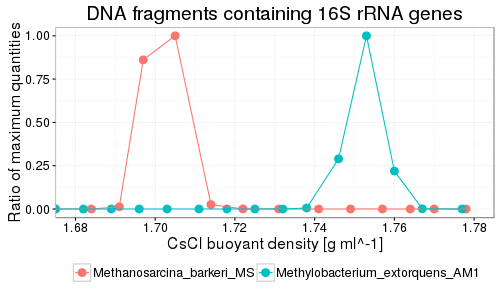

In [660]:
%%R -w 500 -h 300

# max possible shift for M barkeri (using mean G+C)
max_shift = 1.727326 + 0.036

# plotting
p = ggplot(df, aes(BD_min, rel_abund, color=taxon)) +
    geom_point(size=3.5) +
    geom_line() +
    #geom_vline(xintercept=c(1.698416, 1.727326), linetype='dashed', alpha=0.5) +
    #geom_vline(xintercept=c(max_shift), linetype='dashed', alpha=0.5, color='blue') +
    scale_x_continuous(limits=c(1.68, 1.78), breaks=seq(1.68, 1.78, 0.02)) +
    scale_color_discrete('') +
    labs(x='CsCl buoyant density [g ml^-1]', y='Ratio of maximum quantities', 
         title='DNA fragments containing 16S rRNA genes') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'bottom'
    )
p